In [10]:
import os
import sys

# 現在のディレクトリを取得
current_dir = os.getcwd()

# 一つ前のディレクトリを取得(srcディレクトリへのpathを作成するため)
project_dir = os.path.dirname(current_dir)

# 'src'ディレクトリへのパスを作成
src_dir = os.path.join(project_dir, 'src')

# 'src'ディレクトリのpathをPythonのパスに追加
sys.path.append(src_dir)

In [ ]:
import models
import features
import validation
import numpy as np
import pandas as pd

#次の候補の数
number_of_selecting_samples = 5

# 実験結果データの読み込み
dataset = pd.read_csv('./../data/raw/result.csv', index_col=0, header=0)
x_prediction = pd.read_csv('./../data/candidate/remaining_samples.csv', index_col=0, header=0)

# データ分割
y = dataset.iloc[:, 0]  # 目的変数
x = dataset.iloc[:, 1:]  # 説明変数

# 標準偏差が 0 の特徴量の削除
deleting_variables = x.columns[x.std() == 0]
x = x.drop(deleting_variables, axis=1)
x_prediction = x_prediction.drop(deleting_variables, axis=1)
cumulative_variance = np.zeros(x_prediction.shape[0]) # MI で必要な "ばらつき" を 0 で初期化

# ガウス過程回帰(最初にカーネル関数を選択する)
regression_method = 'gpr_one_kernel'
acquisition_function = "PTR" #PTR PI EI MI

cumulative_variance = np.zeros(x_prediction.shape[0]) # MI で必要な "ばらつき" を 0 で初期化
relaxation = 0.01 #EI PI
delta = 10**-6 #MI

next_samples = pd.DataFrame([], columns=x_prediction.columns) # 次のサンプルを入れる変数を準備

for sample_number in range(number_of_selecting_samples):
    # オートスケーリング
    autoscaled_y = (y - y.mean()) / y.std()
    autoscaled_x = (x - x.mean()) / x.std()
    autoscaled_x_prediction = (x_prediction - x.mean()) / x.std()

    # モデル構築
    model = models.gpr_one_kernel(2,autoscaled_x, autoscaled_y, x)

     # クロスバリデーション
    if sample_number == 0:
        validate = validation.validate_model(regression_method, model,10, autoscaled_x, autoscaled_y, x, y)

    # 予測
    estimated_y_prediction, estimated_y_prediction_std = models.predict(regression_method, model, autoscaled_x_prediction, x_prediction, y)

    estimated_y_prediction, acquisition_function_prediction, acquisition_function = models.acquisition_function(x_prediction, estimated_y_prediction, estimated_y_prediction_std, delta, acquisition_function, relaxation, y, regression_method)


    # 保存
    estimated_y_prediction = pd.DataFrame(estimated_y_prediction, x_prediction.index, columns=['estimated_y'])
    estimated_y_prediction_std = pd.DataFrame(estimated_y_prediction_std, x_prediction.index, columns=['std_of_estimated_y'])
    acquisition_function_prediction = pd.DataFrame(acquisition_function_prediction, index=x_prediction.index, columns=['acquisition_function'])
    if sample_number == 0:
        estimated_y_prediction.to_csv('estimated_y_prediction_{0}.csv'.format(regression_method))  # 予測結果を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
        estimated_y_prediction_std.to_csv('estimated_y_prediction_{0}_std.csv'.format(regression_method))  # 予測値の標準偏差を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
        acquisition_function_prediction.to_csv('acquisition_function_prediction_{0}_{1}.csv'.format(regression_method, acquisition_function))  # 獲得関数を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください

    # 次のサンプル
    next_samples = pd.concat([next_samples, x_prediction.loc[acquisition_function_prediction.idxmax()]], axis=0)
    
    # x, y, x_prediction, cumulative_variance の更新
    x = pd.concat([x, x_prediction.loc[acquisition_function_prediction.idxmax()]], axis=0)
    y = pd.concat([y, estimated_y_prediction.loc[acquisition_function_prediction.idxmax()].iloc[0]], axis=0)
    x_prediction = x_prediction.drop(acquisition_function_prediction.idxmax(), axis=0)
    cumulative_variance = np.delete(cumulative_variance, np.where(acquisition_function_prediction.index == acquisition_function_prediction.iloc[:, 0].idxmax())[0][0])
    print('sample number : {0} / {1}'.format(sample_number + 1, number_of_selecting_samples))
            
next_samples.to_csv('./../data/interim/next_samples_bo_{0}_{1}.csv'.format(regression_method, acquisition_function)) # csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください

1 / 11
2 / 11
3 / 11
4 / 11


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakih

5 / 11
6 / 11


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warning

7 / 11
8 / 11
9 / 11
10 / 11
11 / 11
クロスバリデーションで選択されたカーネル関数の番号 : 2
クロスバリデーションで選択されたカーネル関数 : 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1) + 1**2 * DotProduct(sigma_0=1)


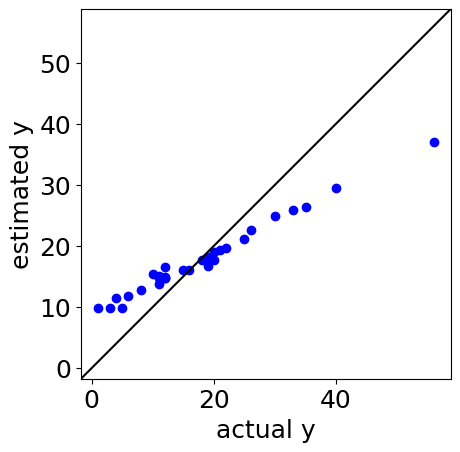

r^2 for training data : 0.752672112513344
RMSE for training data : 5.900724124343347
MAE for training data : 4.573054081652065


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihi

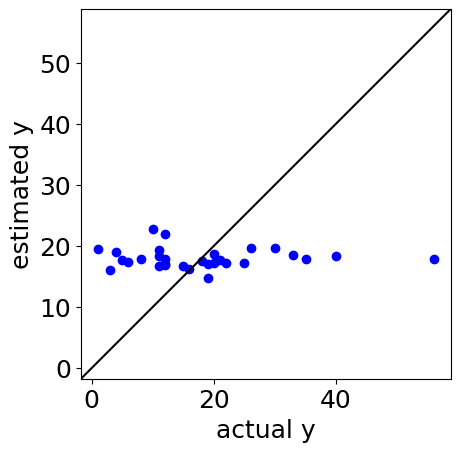

r^2 in cross-validation : -0.026465049885433967
RMSE in cross-validation : 12.021006996343912
MAE in cross-validation : 9.241623414117772
sample number : 1 / 5
1 / 11
2 / 11
3 / 11
4 / 11
5 / 11


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaz

6 / 11
7 / 11
8 / 11
9 / 11
10 / 11
11 / 11
クロスバリデーションで選択されたカーネル関数の番号 : 10
クロスバリデーションで選択されたカーネル関数 : 1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1) + 1**2 * DotProduct(sigma_0=1)


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


sample number : 2 / 5
1 / 11
2 / 11
3 / 11
4 / 11
5 / 11


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaz

6 / 11
7 / 11
8 / 11


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


9 / 11
10 / 11
11 / 11


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/op

クロスバリデーションで選択されたカーネル関数の番号 : 10
クロスバリデーションで選択されたカーネル関数 : 1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1) + 1**2 * DotProduct(sigma_0=1)
sample number : 3 / 5
1 / 11
2 / 11
3 / 11
4 / 11


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/op

5 / 11
6 / 11
7 / 11


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


8 / 11
9 / 11
10 / 11


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


11 / 11
クロスバリデーションで選択されたカーネル関数の番号 : 2
クロスバリデーションで選択されたカーネル関数 : 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1) + 1**2 * DotProduct(sigma_0=1)


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


sample number : 4 / 5
1 / 11
2 / 11
3 / 11
4 / 11


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

5 / 11
6 / 11


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihirot

7 / 11
8 / 11
9 / 11


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

10 / 11
11 / 11
クロスバリデーションで選択されたカーネル関数の番号 : 7
クロスバリデーションで選択されたカーネル関数 : 1**2 * Matern(length_scale=1, nu=0.5) + WhiteKernel(noise_level=1)
sample number : 5 / 5


In [18]:
import models
import features
import validation
import numpy as np
import pandas as pd

#次の候補の数
number_of_selecting_samples = 5

# 実験結果データの読み込み
dataset = pd.read_csv('./../data/raw/result.csv', index_col=0, header=0)
x_prediction = pd.read_csv('./../data/candidate/remaining_samples.csv', index_col=0, header=0)

# データ分割
y = dataset.iloc[:, 0]  # 目的変数
x = dataset.iloc[:, 1:]  # 説明変数

# 標準偏差が 0 の特徴量の削除
deleting_variables = x.columns[x.std() == 0]
x = x.drop(deleting_variables, axis=1)
x_prediction = x_prediction.drop(deleting_variables, axis=1)
cumulative_variance = np.zeros(x_prediction.shape[0]) # MI で必要な "ばらつき" を 0 で初期化

# ガウス過程回帰(最初にカーネル関数を選択する)
regression_method = 'gpr_kernels'
acquisition_function = "PTR" #PTR PI EI MI

cumulative_variance = np.zeros(x_prediction.shape[0]) # MI で必要な "ばらつき" を 0 で初期化
relaxation = 0.01 #EI PI
delta = 10**-6 #MI

next_samples = pd.DataFrame([], columns=x_prediction.columns) # 次のサンプルを入れる変数を準備

for sample_number in range(number_of_selecting_samples):
    # オートスケーリング
    autoscaled_y = (y - y.mean()) / y.std()
    autoscaled_x = (x - x.mean()) / x.std()
    autoscaled_x_prediction = (x_prediction - x.mean()) / x.std()

    # モデル構築
    model = models.gpr_kernels(2,autoscaled_x, autoscaled_y, x, y)

     # クロスバリデーション
    if sample_number == 0:
        validate = validation.validate_model(regression_method, model,10, autoscaled_x, autoscaled_y, x, y)

    # 予測
    estimated_y_prediction, estimated_y_prediction_std = models.predict(regression_method, model, autoscaled_x_prediction, x_prediction, y)

    estimated_y_prediction, acquisition_function_prediction, acquisition_function = models.acquisition_function(x_prediction, estimated_y_prediction, estimated_y_prediction_std, delta, acquisition_function, relaxation, y, regression_method)


    # 保存
    estimated_y_prediction = pd.DataFrame(estimated_y_prediction, x_prediction.index, columns=['estimated_y'])
    estimated_y_prediction_std = pd.DataFrame(estimated_y_prediction_std, x_prediction.index, columns=['std_of_estimated_y'])
    acquisition_function_prediction = pd.DataFrame(acquisition_function_prediction, index=x_prediction.index, columns=['acquisition_function'])
    if sample_number == 0:
        estimated_y_prediction.to_csv('estimated_y_prediction_{0}.csv'.format(regression_method))  # 予測結果を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
        estimated_y_prediction_std.to_csv('estimated_y_prediction_{0}_std.csv'.format(regression_method))  # 予測値の標準偏差を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
        acquisition_function_prediction.to_csv('acquisition_function_prediction_{0}_{1}.csv'.format(regression_method, acquisition_function))  # 獲得関数を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください

    # 次のサンプル
    next_samples = pd.concat([next_samples, x_prediction.loc[acquisition_function_prediction.idxmax()]], axis=0)
    
    # x, y, x_prediction, cumulative_variance の更新
    x = pd.concat([x, x_prediction.loc[acquisition_function_prediction.idxmax()]], axis=0)
    y = pd.concat([y, estimated_y_prediction.loc[acquisition_function_prediction.idxmax()].iloc[0]], axis=0)
    x_prediction = x_prediction.drop(acquisition_function_prediction.idxmax(), axis=0)
    cumulative_variance = np.delete(cumulative_variance, np.where(acquisition_function_prediction.index == acquisition_function_prediction.iloc[:, 0].idxmax())[0][0])
    print('sample number : {0} / {1}'.format(sample_number + 1, number_of_selecting_samples))
            
next_samples.to_csv('./../data/interim/next_samples_bo_{0}_{1}.csv'.format(regression_method, acquisition_function)) # csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください